In [1]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Add path to submodules
sys.path.append(r"C:\Users\micha\OneDrive\Documents\code\submodules")
from eodhd import Security

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Risk Model Implementation

**Factor-Based Risk Model with Ex-Ante Analytics**

This notebook implements a fundamental factor risk model including:
- Factor variance-covariance matrix construction
- Ex-ante tracking error calculation
- Portfolio beta decomposition
- Factor contribution analysis
- Risk attribution

**Portfolio Setup:**
- **Benchmark:** 60% IVV (S&P 500) / 40% AGG (Aggregate Bonds)
- **Portfolio:** 50% XLG (Large Cap) / 50% TLT (Long-Term Treasuries)

**Risk Factors:** Russell Style ETFs
- IWD (Value)
- IWF (Growth) 
- IWM (Small Cap)
- IWR (Mid Cap)
- AGG (Fixed Income)
- TLT (Duration)

In [ ]:
class FactorRiskModel:
    """
    Factor-based risk model for portfolio analysis.
    
    Computes ex-ante tracking error, beta decomposition, and factor contributions
    using a factor model framework.
    
    Parameters
    ----------
    factors : list of str
        List of factor ticker symbols (e.g., Russell style ETFs)
    lookback_days : int
        Historical period for estimating factor covariance (default: 252 trading days)
    """
    
    def __init__(self, factors: list, lookback_days: int = 252):
        self.factors = factors
        self.lookback_days = lookback_days
        self.factor_returns = None
        self.factor_covariance = None
        self.factor_correlation = None
        
    def fetch_factor_data(self, start_date: str = None, end_date: str = None):
        """
        Fetch historical returns for all factors using Security class.
        
        Parameters
        ----------
        start_date : str, optional
            Start date for historical data
        end_date : str, optional
            End date for historical data
        """
        print(f"Fetching data for {len(self.factors)} factors...")
        
        if start_date is None:
            start_date = (datetime.now() - timedelta(days=self.lookback_days + 30)).strftime('%Y-%m-%d')
        if end_date is None:
            end_date = datetime.now().strftime('%Y-%m-%d')
        
        # Fetch all factors at once
        sec = Security(ticker=self.factors, start=start_date, end=end_date)
        self.factor_returns = sec.returns
        
        print(f"✓ Fetched {len(self.factor_returns)} days of factor returns")
        print(f"  Date range: {self.factor_returns.index[0]} to {self.factor_returns.index[-1]}")
        
        return self.factor_returns
    
    def estimate_factor_covariance(self, annualize: bool = True):
        """
        Estimate factor variance-covariance matrix from historical returns.
        
        Parameters
        ----------
        annualize : bool
            If True, annualize the covariance matrix (multiply by 252)
        
        Returns
        -------
        pd.DataFrame
            Factor covariance matrix
        """
        if self.factor_returns is None:
            raise ValueError("Factor returns not loaded. Call fetch_factor_data() first.")
        
        # Calculate covariance matrix
        self.factor_covariance = self.factor_returns.cov()
        
        if annualize:
            self.factor_covariance *= 252
        
        # Calculate correlation matrix
        self.factor_correlation = self.factor_returns.corr()
        
        print(f"✓ Factor covariance matrix estimated ({self.factor_covariance.shape})")
        
        return self.factor_covariance
    
    def calculate_portfolio_factor_exposures(self, portfolio_holdings: dict, 
                                             asset_returns: pd.DataFrame = None):
        """
        Calculate portfolio exposures to each factor using regression.
        
        Parameters
        ----------
        portfolio_holdings : dict
            Dictionary of {ticker: weight} for portfolio holdings
        asset_returns : pd.DataFrame, optional
            Historical returns for portfolio assets. If None, will fetch.
        
        Returns
        -------
        pd.Series
            Factor exposures (betas) for the portfolio
        """
        if self.factor_returns is None:
            raise ValueError("Factor returns not loaded. Call fetch_factor_data() first.")
        
        # Fetch asset returns if not provided
        if asset_returns is None:
            tickers = list(portfolio_holdings.keys())
            start_date = str(self.factor_returns.index[0])[:10] if isinstance(self.factor_returns.index[0], str) else self.factor_returns.index[0].strftime('%Y-%m-%d')
            end_date = str(self.factor_returns.index[-1])[:10] if isinstance(self.factor_returns.index[-1], str) else self.factor_returns.index[-1].strftime('%Y-%m-%d')
            sec = Security(ticker=tickers, start=start_date, end=end_date)
            asset_returns = sec.returns
        
        # Calculate portfolio returns
        weights = pd.Series(portfolio_holdings)
        portfolio_returns = (asset_returns[list(portfolio_holdings.keys())] * weights).sum(axis=1)
        
        # Align data
        aligned_data = pd.concat([portfolio_returns, self.factor_returns], axis=1).dropna()
        y = aligned_data.iloc[:, 0]  # Portfolio returns
        X = aligned_data.iloc[:, 1:]  # Factor returns
        
        # Add constant for alpha
        X = pd.concat([pd.Series(1, index=X.index, name='Alpha'), X], axis=1)
        
        # OLS regression: R_p = alpha + sum(beta_i * F_i) + epsilon
        betas = np.linalg.lstsq(X.values, y.values, rcond=None)[0]
        
        factor_exposures = pd.Series(betas[1:], index=self.factor_returns.columns, name='Beta')
        alpha = betas[0]
        
        # R-squared
        y_pred = X.values @ betas
        ss_res = ((y.values - y_pred) ** 2).sum()
        ss_tot = ((y.values - y.values.mean()) ** 2).sum()
        r_squared = 1 - (ss_res / ss_tot)
        
        print(f"\n✓ Factor exposures calculated (R² = {r_squared:.3f}, Alpha = {alpha*252*100:.2f}% annualized)")
        
        return factor_exposures, alpha, r_squared
    
    def calculate_tracking_error(self, portfolio_holdings: dict, 
                                 benchmark_holdings: dict,
                                 ex_ante: bool = True):
        """
        Calculate ex-ante or ex-post tracking error between portfolio and benchmark.
        
        Parameters
        ----------
        portfolio_holdings : dict
            Portfolio weights {ticker: weight}
        benchmark_holdings : dict
            Benchmark weights {ticker: weight}
        ex_ante : bool
            If True, use factor model for ex-ante TE. If False, use historical TE.
        
        Returns
        -------
        dict
            Tracking error statistics
        """
        # Get factor exposures for portfolio and benchmark
        port_betas, port_alpha, port_r2 = self.calculate_portfolio_factor_exposures(portfolio_holdings)
        bench_betas, bench_alpha, bench_r2 = self.calculate_portfolio_factor_exposures(benchmark_holdings)
        
        # Active exposures
        active_exposures = port_betas - bench_betas
        
        if ex_ante:
            # Ex-ante TE using factor covariance
            if self.factor_covariance is None:
                self.estimate_factor_covariance(annualize=True)
            
            # TE² = beta_active' * Cov_factors * beta_active
            te_variance = active_exposures.values @ self.factor_covariance.values @ active_exposures.values
            te_annual = np.sqrt(te_variance)
            
            # Factor contributions to tracking error
            marginal_contributions = self.factor_covariance.values @ active_exposures.values
            factor_te_contributions = active_exposures.values * marginal_contributions
            factor_te_pct = factor_te_contributions / te_variance * 100
            
            te_decomp = pd.DataFrame({
                'Active_Exposure': active_exposures,
                'TE_Contribution': factor_te_contributions,
                'TE_Contribution_pct': factor_te_pct
            }).sort_values('TE_Contribution', key=abs, ascending=False)
            
        else:
            # Ex-post TE from historical returns
            # Fetch actual returns
            all_tickers = list(set(list(portfolio_holdings.keys()) + list(benchmark_holdings.keys())))
            start_date = str(self.factor_returns.index[0])[:10] if isinstance(self.factor_returns.index[0], str) else self.factor_returns.index[0].strftime('%Y-%m-%d')
            end_date = str(self.factor_returns.index[-1])[:10] if isinstance(self.factor_returns.index[-1], str) else self.factor_returns.index[-1].strftime('%Y-%m-%d')
            sec = Security(ticker=all_tickers, start=start_date, end=end_date)
            returns = sec.returns
            
            # Portfolio and benchmark returns
            port_ret = (returns[list(portfolio_holdings.keys())] * pd.Series(portfolio_holdings)).sum(axis=1)
            bench_ret = (returns[list(benchmark_holdings.keys())] * pd.Series(benchmark_holdings)).sum(axis=1)
            
            # Active returns
            active_ret = port_ret - bench_ret
            te_annual = active_ret.std() * np.sqrt(252)
            te_decomp = None
        
        return {
            'tracking_error_annual': te_annual,
            'portfolio_betas': port_betas,
            'benchmark_betas': bench_betas,
            'active_exposures': active_exposures,
            'te_decomposition': te_decomp,
            'portfolio_r2': port_r2,
            'benchmark_r2': bench_r2
        }
    
    def calculate_portfolio_risk(self, holdings: dict):
        """
        Calculate total portfolio risk using factor model.
        
        Parameters
        ----------
        holdings : dict
            Portfolio holdings {ticker: weight}
        
        Returns
        -------
        dict
            Risk statistics including volatility and factor contributions
        """
        # Get factor exposures
        betas, alpha, r_squared = self.calculate_portfolio_factor_exposures(holdings)
        
        if self.factor_covariance is None:
            self.estimate_factor_covariance(annualize=True)
        
        # Portfolio variance = beta' * Cov * beta
        portfolio_variance = betas.values @ self.factor_covariance.values @ betas.values
        portfolio_vol = np.sqrt(portfolio_variance)
        
        # Factor risk contributions
        marginal_risk = self.factor_covariance.values @ betas.values
        factor_risk_contrib = betas.values * marginal_risk
        factor_risk_pct = factor_risk_contrib / portfolio_variance * 100
        
        risk_decomp = pd.DataFrame({
            'Beta': betas,
            'Risk_Contribution': factor_risk_contrib,
            'Risk_Contribution_pct': factor_risk_pct
        }).sort_values('Risk_Contribution', key=abs, ascending=False)
        
        return {
            'portfolio_volatility': portfolio_vol,
            'portfolio_variance': portfolio_variance,
            'factor_betas': betas,
            'risk_decomposition': risk_decomp,
            'r_squared': r_squared,
            'alpha': alpha
        }
    
    def visualize_factor_correlation(self, figsize=(10, 8)):
        """Plot factor correlation heatmap."""
        if self.factor_correlation is None:
            raise ValueError("Factor correlation not calculated. Run estimate_factor_covariance() first.")
        
        plt.figure(figsize=figsize)
        sns.heatmap(self.factor_correlation, annot=True, fmt='.2f', 
                   cmap='RdBu_r', center=0, vmin=-1, vmax=1,
                   square=True, linewidths=1, cbar_kws={'label': 'Correlation'})
        plt.title('Factor Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
    
    def visualize_risk_decomposition(self, risk_stats: dict, title: str = "Risk Decomposition"):
        """
        Visualize factor contributions to portfolio risk.
        
        Parameters
        ----------
        risk_stats : dict
            Output from calculate_portfolio_risk()
        title : str
            Plot title
        """
        decomp = risk_stats['risk_decomposition']
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Factor betas
        decomp['Beta'].plot(kind='barh', ax=ax1, color='steelblue', edgecolor='black')
        ax1.axvline(0, color='red', linestyle='--', linewidth=1)
        ax1.set_xlabel('Factor Beta', fontsize=11, fontweight='bold')
        ax1.set_title('Factor Exposures (Betas)', fontsize=12, fontweight='bold')
        ax1.grid(axis='x', alpha=0.3)
        
        # Risk contributions
        colors = ['green' if x > 0 else 'red' for x in decomp['Risk_Contribution_pct']]
        decomp['Risk_Contribution_pct'].plot(kind='barh', ax=ax2, color=colors, 
                                             alpha=0.7, edgecolor='black')
        ax2.set_xlabel('Risk Contribution (%)', fontsize=11, fontweight='bold')
        ax2.set_title('Factor Risk Contributions', fontsize=12, fontweight='bold')
        ax2.grid(axis='x', alpha=0.3)
        
        fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        
    def generate_risk_report(self, portfolio_holdings: dict, 
                            benchmark_holdings: dict,
                            portfolio_name: str = "Portfolio",
                            benchmark_name: str = "Benchmark"):
        """
        Generate comprehensive risk report.
        
        Parameters
        ----------
        portfolio_holdings : dict
            Portfolio weights
        benchmark_holdings : dict
            Benchmark weights
        portfolio_name : str
            Name for portfolio
        benchmark_name : str
            Name for benchmark
        """
        print("=" * 80)
        print(f"RISK ANALYSIS REPORT: {portfolio_name} vs {benchmark_name}")
        print("=" * 80)
        
        # Portfolio risk
        print(f"\n{portfolio_name} Risk Analysis:")
        print("-" * 80)
        port_risk = self.calculate_portfolio_risk(portfolio_holdings)
        print(f"  Annual Volatility:............... {port_risk['portfolio_volatility']*100:.2f}%")
        print(f"  R² (Factor Model):............... {port_risk['r_squared']:.3f}")
        print(f"  Alpha (Annualized):.............. {port_risk['alpha']*252*100:.2f}%")
        
        # Benchmark risk
        print(f"\n{benchmark_name} Risk Analysis:")
        print("-" * 80)
        bench_risk = self.calculate_portfolio_risk(benchmark_holdings)
        print(f"  Annual Volatility:............... {bench_risk['portfolio_volatility']*100:.2f}%")
        print(f"  R² (Factor Model):............... {bench_risk['r_squared']:.3f}")
        print(f"  Alpha (Annualized):.............. {bench_risk['alpha']*252*100:.2f}%")
        
        # Tracking error
        print(f"\nTracking Error Analysis:")
        print("-" * 80)
        te_stats = self.calculate_tracking_error(portfolio_holdings, benchmark_holdings, ex_ante=True)
        print(f"  Ex-Ante Tracking Error:.......... {te_stats['tracking_error_annual']*100:.2f}%")
        
        print(f"\nActive Factor Exposures:")
        print("-" * 80)
        for factor, exposure in te_stats['active_exposures'].items():
            print(f"  {factor:.<30} {exposure:>8.3f}")
        
        if te_stats['te_decomposition'] is not None:
            print(f"\nTracking Error Decomposition:")
            print("-" * 80)
            print(te_stats['te_decomposition'].to_string())
        
        print("\n" + "=" * 80)
        
        return {
            'portfolio_risk': port_risk,
            'benchmark_risk': bench_risk,
            'tracking_error': te_stats
        }

## Define Risk Factors

Using Russell Style ETFs as risk factors

In [3]:
# Define risk factors (Russell Style ETFs + Fixed Income)
RISK_FACTORS = [
    'IWD.US',   # iShares Russell 1000 Value ETF
    'IWF.US',   # iShares Russell 1000 Growth ETF
    'IWM.US',   # iShares Russell 2000 ETF (Small Cap)
    'IWR.US',   # iShares Russell Mid-Cap ETF
    'AGG.US',   # iShares Core U.S. Aggregate Bond ETF
    'TLT.US'    # iShares 20+ Year Treasury Bond ETF (Duration factor)
]

# Portfolio definition: 50% XLG / 50% TLT
PORTFOLIO = {
    'XLG.US': 0.50,  # Invesco S&P 500 Top 50 ETF (Large Cap)
    'TLT.US': 0.50   # iShares 20+ Year Treasury Bond ETF
}

# Benchmark definition: 60% IVV / 40% AGG
BENCHMARK = {
    'IVV.US': 0.60,  # iShares Core S&P 500 ETF
    'AGG.US': 0.40   # iShares Core U.S. Aggregate Bond ETF
}

print("Risk Model Configuration:")
print("=" * 60)
print(f"\nRisk Factors ({len(RISK_FACTORS)}):")
for factor in RISK_FACTORS:
    print(f"  • {factor}")

print(f"\nPortfolio Holdings:")
for ticker, weight in PORTFOLIO.items():
    print(f"  • {ticker}: {weight*100:.0f}%")

print(f"\nBenchmark Holdings:")
for ticker, weight in BENCHMARK.items():
    print(f"  • {ticker}: {weight*100:.0f}%")
print("=" * 60)

Risk Model Configuration:

Risk Factors (6):
  • IWD.US
  • IWF.US
  • IWM.US
  • IWR.US
  • AGG.US
  • TLT.US

Portfolio Holdings:
  • XLG.US: 50%
  • TLT.US: 50%

Benchmark Holdings:
  • IVV.US: 60%
  • AGG.US: 40%


## Initialize Risk Model and Fetch Data

In [4]:
# Initialize risk model with 1-year lookback
risk_model = FactorRiskModel(factors=RISK_FACTORS, lookback_days=252)

# Fetch factor returns (1 year of daily data)
factor_returns = risk_model.fetch_factor_data()

# Display first few rows
print("\nFactor Returns (First 5 days):")
print(factor_returns.head())

Fetching data for 6 factors...
✓ Fetched 195 days of factor returns
  Date range: 2025-02-21 to 2025-11-28

Factor Returns (First 5 days):
ticker        AGG.US    IWD.US    IWF.US    IWM.US    IWR.US    TLT.US
date                                                                  
2025-02-21  0.004294 -0.013714 -0.022951 -0.029229 -0.022116  0.012013
2025-02-24  0.001733  0.001193 -0.010278 -0.007235 -0.002339  0.002896
2025-02-25  0.006192  0.001244 -0.010082 -0.003799 -0.002904  0.017101
2025-02-26  0.001618 -0.003632  0.003648  0.001253  0.000000  0.005889
2025-02-27 -0.001516 -0.003227 -0.026905 -0.015372 -0.011134 -0.007094
✓ Fetched 195 days of factor returns
  Date range: 2025-02-21 to 2025-11-28

Factor Returns (First 5 days):
ticker        AGG.US    IWD.US    IWF.US    IWM.US    IWR.US    TLT.US
date                                                                  
2025-02-21  0.004294 -0.013714 -0.022951 -0.029229 -0.022116  0.012013
2025-02-24  0.001733  0.001193 -0.010278 -0

## Estimate Factor Covariance Matrix

In [5]:
# Estimate annualized factor covariance matrix
factor_cov = risk_model.estimate_factor_covariance(annualize=True)

print("\nAnnualized Factor Covariance Matrix:")
print(factor_cov.round(4))

print("\nAnnualized Factor Volatilities:")
for factor in factor_cov.columns:
    vol = np.sqrt(factor_cov.loc[factor, factor])
    print(f"  {factor}: {vol*100:.2f}%")

✓ Factor covariance matrix estimated ((6, 6))

Annualized Factor Covariance Matrix:
ticker  AGG.US  IWD.US  IWF.US  IWM.US  IWR.US  TLT.US
ticker                                                
AGG.US  0.0021  0.0010 -0.0000  0.0009  0.0010  0.0053
IWD.US  0.0010  0.0297  0.0358  0.0382  0.0349  0.0026
IWF.US -0.0000  0.0358  0.0625  0.0515  0.0457  0.0004
IWM.US  0.0009  0.0382  0.0515  0.0605  0.0488  0.0022
IWR.US  0.0010  0.0349  0.0457  0.0488  0.0437  0.0027
TLT.US  0.0053  0.0026  0.0004  0.0022  0.0027  0.0150

Annualized Factor Volatilities:
  AGG.US: 4.61%
  IWD.US: 17.22%
  IWF.US: 25.00%
  IWM.US: 24.59%
  IWR.US: 20.91%
  TLT.US: 12.26%


## Visualize Factor Correlation

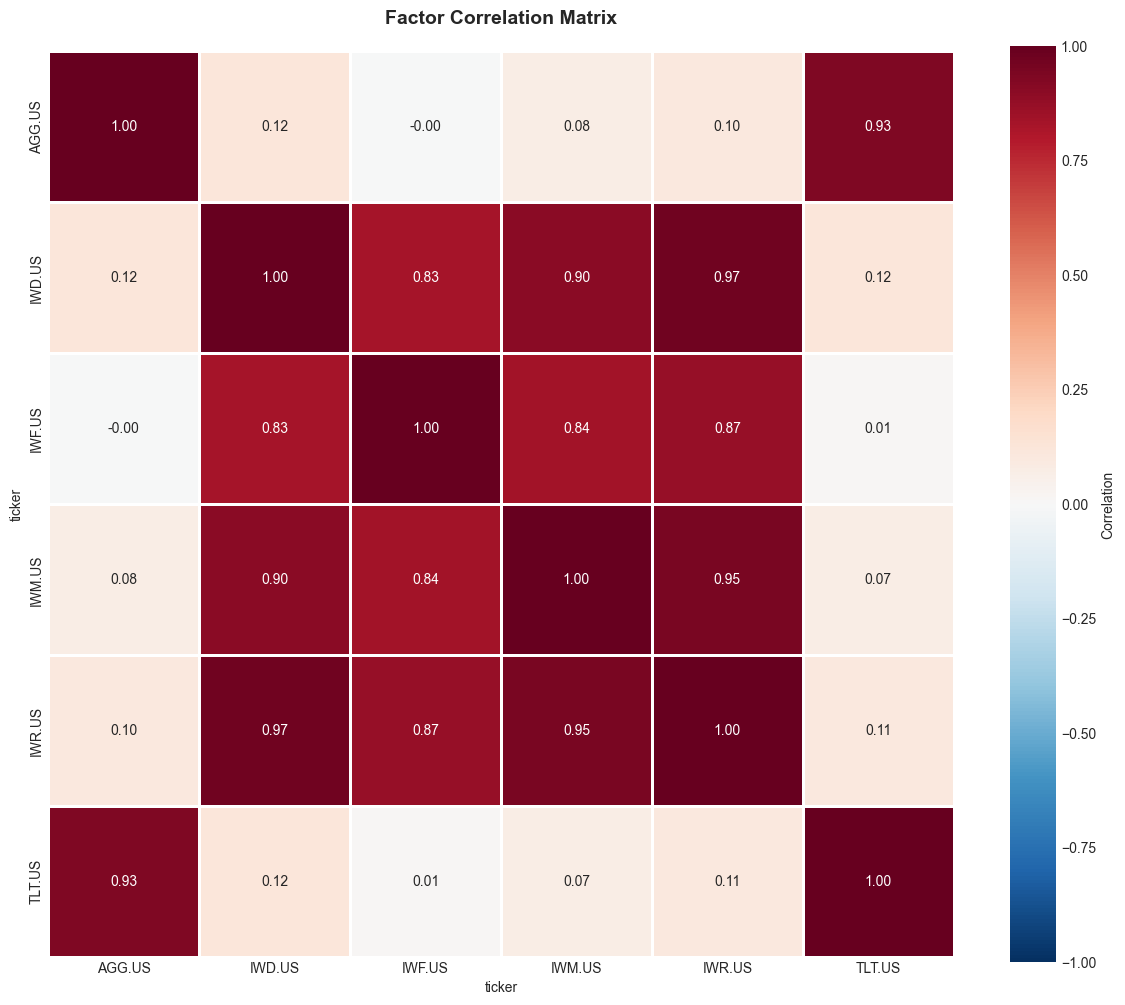

In [6]:
# Visualize factor correlations
risk_model.visualize_factor_correlation(figsize=(12, 10))

## Calculate Portfolio Risk

In [7]:
# Calculate portfolio risk decomposition
portfolio_risk = risk_model.calculate_portfolio_risk(PORTFOLIO)

print("\n" + "=" * 80)
print("PORTFOLIO RISK ANALYSIS (50% XLG / 50% TLT)")
print("=" * 80)
print(f"\nAnnual Volatility:............... {portfolio_risk['portfolio_volatility']*100:.2f}%")
print(f"R² (Factor Model):............... {portfolio_risk['r_squared']:.3f}")
print(f"Alpha (Annualized):.............. {portfolio_risk['alpha']*252*100:.2f}%")

print("\nFactor Betas:")
print(portfolio_risk['factor_betas'].to_string())

print("\nRisk Decomposition:")
print(portfolio_risk['risk_decomposition'].to_string())

AttributeError: 'str' object has no attribute 'strftime'

## Visualize Portfolio Risk Decomposition

In [ ]:
# Visualize portfolio risk decomposition
risk_model.visualize_risk_decomposition(portfolio_risk, 
                                        title="Portfolio Risk Decomposition (50% XLG / 50% TLT)")

## Calculate Benchmark Risk

In [ ]:
# Calculate benchmark risk decomposition
benchmark_risk = risk_model.calculate_portfolio_risk(BENCHMARK)

print("\n" + "=" * 80)
print("BENCHMARK RISK ANALYSIS (60% IVV / 40% AGG)")
print("=" * 80)
print(f"\nAnnual Volatility:............... {benchmark_risk['portfolio_volatility']*100:.2f}%")
print(f"R² (Factor Model):............... {benchmark_risk['r_squared']:.3f}")
print(f"Alpha (Annualized):.............. {benchmark_risk['alpha']*252*100:.2f}%")

print("\nFactor Betas:")
print(benchmark_risk['factor_betas'].to_string())

print("\nRisk Decomposition:")
print(benchmark_risk['risk_decomposition'].to_string())

In [ ]:
# Visualize benchmark risk decomposition
risk_model.visualize_risk_decomposition(benchmark_risk, 
                                        title="Benchmark Risk Decomposition (60% IVV / 40% AGG)")

## Calculate Ex-Ante Tracking Error

In [ ]:
# Calculate ex-ante tracking error
te_stats = risk_model.calculate_tracking_error(PORTFOLIO, BENCHMARK, ex_ante=True)

print("\n" + "=" * 80)
print("TRACKING ERROR ANALYSIS")
print("=" * 80)
print(f"\nEx-Ante Tracking Error:.......... {te_stats['tracking_error_annual']*100:.2f}%")

print("\nActive Factor Exposures (Portfolio - Benchmark):")
print("-" * 80)
for factor, exposure in te_stats['active_exposures'].items():
    direction = "LONG" if exposure > 0 else "SHORT"
    print(f"  {factor:.<30} {exposure:>8.3f}  ({direction})")

print("\nTracking Error Decomposition:")
print("-" * 80)
if te_stats['te_decomposition'] is not None:
    print(te_stats['te_decomposition'].to_string())

## Visualize Active Exposures and TE Contributions

In [ ]:
# Visualize tracking error decomposition
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Active exposures
ax1 = axes[0]
colors_active = ['green' if x > 0 else 'red' for x in te_stats['active_exposures']]
te_stats['active_exposures'].plot(kind='barh', ax=ax1, color=colors_active, 
                                   alpha=0.7, edgecolor='black')
ax1.axvline(0, color='black', linestyle='-', linewidth=2)
ax1.set_xlabel('Active Exposure (Beta)', fontsize=11, fontweight='bold')
ax1.set_title('Active Factor Exposures\n(Portfolio - Benchmark)', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# TE contributions
if te_stats['te_decomposition'] is not None:
    ax2 = axes[1]
    te_contrib = te_stats['te_decomposition']['TE_Contribution_pct']
    colors_te = ['green' if x > 0 else 'red' for x in te_contrib]
    te_contrib.plot(kind='barh', ax=ax2, color=colors_te, alpha=0.7, edgecolor='black')
    ax2.set_xlabel('TE Contribution (%)', fontsize=11, fontweight='bold')
    ax2.set_title('Tracking Error Contribution by Factor', fontsize=12, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)

plt.suptitle(f'Tracking Error Analysis: Ex-Ante TE = {te_stats["tracking_error_annual"]*100:.2f}%',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Comprehensive Risk Report

In [ ]:
# Generate comprehensive risk report
full_report = risk_model.generate_risk_report(
    portfolio_holdings=PORTFOLIO,
    benchmark_holdings=BENCHMARK,
    portfolio_name="50/50 XLG/TLT Portfolio",
    benchmark_name="60/40 IVV/AGG Benchmark"
)

## Compare Portfolio vs Benchmark Betas

In [ ]:
# Compare portfolio and benchmark factor exposures
beta_comparison = pd.DataFrame({
    'Portfolio': portfolio_risk['factor_betas'],
    'Benchmark': benchmark_risk['factor_betas'],
    'Active': te_stats['active_exposures']
})

print("\n" + "=" * 80)
print("FACTOR EXPOSURE COMPARISON")
print("=" * 80)
print(beta_comparison.to_string())

# Visualize beta comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(beta_comparison))
width = 0.35

bars1 = ax.bar(x - width/2, beta_comparison['Portfolio'], width, 
               label='Portfolio', color='steelblue', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, beta_comparison['Benchmark'], width,
               label='Benchmark', color='coral', alpha=0.8, edgecolor='black')

ax.set_xlabel('Factor', fontsize=12, fontweight='bold')
ax.set_ylabel('Beta', fontsize=12, fontweight='bold')
ax.set_title('Factor Exposures: Portfolio vs Benchmark', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(beta_comparison.index, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.axhline(0, color='black', linestyle='-', linewidth=1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Summary Statistics Table

In [ ]:
# Create comprehensive summary table
summary = pd.DataFrame({
    'Portfolio': [
        f"{portfolio_risk['portfolio_volatility']*100:.2f}%",
        f"{portfolio_risk['r_squared']:.3f}",
        f"{portfolio_risk['alpha']*252*100:.2f}%",
        f"{te_stats['tracking_error_annual']*100:.2f}%",
        "N/A"
    ],
    'Benchmark': [
        f"{benchmark_risk['portfolio_volatility']*100:.2f}%",
        f"{benchmark_risk['r_squared']:.3f}",
        f"{benchmark_risk['alpha']*252*100:.2f}%",
        "0.00%",
        "1.00"
    ]
}, index=['Annual Volatility', 'Factor Model R²', 'Alpha (Annual)', 
          'Tracking Error vs Benchmark', 'Correlation with Benchmark'])

print("\n" + "=" * 80)
print("RISK SUMMARY TABLE")
print("=" * 80)
print(summary.to_string())
print("=" * 80)

# Calculate correlation between portfolio and benchmark returns
all_tickers = list(set(list(PORTFOLIO.keys()) + list(BENCHMARK.keys())))
start_date = str(factor_returns.index[0])[:10] if isinstance(factor_returns.index[0], str) else factor_returns.index[0].strftime('%Y-%m-%d')
end_date = str(factor_returns.index[-1])[:10] if isinstance(factor_returns.index[-1], str) else factor_returns.index[-1].strftime('%Y-%m-%d')
sec = Security(ticker=all_tickers, start=start_date, end=end_date)
returns = sec.returns

port_ret = (returns[list(PORTFOLIO.keys())] * pd.Series(PORTFOLIO)).sum(axis=1)
bench_ret = (returns[list(BENCHMARK.keys())] * pd.Series(BENCHMARK)).sum(axis=1)

correlation = port_ret.corr(bench_ret)
print(f"\nActual Portfolio-Benchmark Correlation: {correlation:.3f}")